In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor  # ✅ 替换模型

# **1. 读取数据（横轴是基因名，纵轴是样本）**
df = pd.read_csv(r"C:\Users\Lyttl\Desktop\rice\shuidao\data\combined_gene_phenotype_data.csv")

# **2. 设置样本 ID 为索引**
df.set_index("Sample", inplace=True)

# **3. 转换为数值型**
df = df.apply(pd.to_numeric, errors="coerce")

# **4. 分离目标变量和特征矩阵**
y = df["Chlorophyll content index"].astype(float)
X = df.drop(columns=["Chlorophyll content index"])

# **5. 处理缺失值**
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# **6. 标准化特征**
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns, index=X.index)

# **7. 特征选择（使用随机森林）**
rf_model_for_selection = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model_for_selection.fit(X_scaled, y)
selector = SelectFromModel(rf_model_for_selection, max_features=10000, threshold="mean")
X_selected = selector.transform(X_scaled)
print("选择的特征数:", X_selected.shape[1])

# **8. 对目标变量进行对数变换**
transformer = FunctionTransformer(np.log1p, validate=True)
y_transformed = transformer.fit_transform(y.values.reshape(-1, 1)).ravel()

# **9. 交叉验证设置**
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# **10. 超参数搜索空间（Random Forest）**
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=kf,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)
grid_search_rf.fit(X_selected, y_transformed)
best_rf_model = grid_search_rf.best_estimator_

# **11. 评估函数**
def evaluate(model, X, y_true):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    pcc, _ = pearsonr(y_true, y_pred)
    return mse, r2, mae, rmse, pcc

# **12. 训练 + 验证 + 测试**
def train_and_evaluate(model, X_train, X_val, X_test, y_train, y_val, y_test):
    model.fit(X_train, y_train)
    mse_train, r2_train, mae_train, rmse_train, pcc_train = evaluate(model, X_train, y_train)
    mse_val, r2_val, mae_val, rmse_val, pcc_val = evaluate(model, X_val, y_val)
    mse_test, r2_test, mae_test, rmse_test, pcc_test = evaluate(model, X_test, y_test)
    
    return r2_train, r2_val, r2_test, mse_train, mse_val, mse_test, mae_train, mae_val, mae_test, rmse_train, rmse_val, rmse_test, pcc_train, pcc_val, pcc_test

# **13. 划分数据集**
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y_transformed, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# **14. 模型评估**
metrics_rf = train_and_evaluate(best_rf_model, X_train, X_val, X_test, y_train, y_val, y_test)

# **15. 打印评估结果**
def print_metrics(name, metrics):
    print(f"{name} - 训练集 R²: {metrics[0]:.4f}, 验证集 R²: {metrics[1]:.4f}, 测试集 R²: {metrics[2]:.4f}")
    print(f"{name} - 训练集 MSE: {metrics[3]:.4f}, 验证集 MSE: {metrics[4]:.4f}, 测试集 MSE: {metrics[5]:.4f}")
    print(f"{name} - 训练集 MAE: {metrics[6]:.4f}, 验证集 MAE: {metrics[7]:.4f}, 测试集 MAE: {metrics[8]:.4f}")
    print(f"{name} - 训练集 RMSE: {metrics[9]:.4f}, 验证集 RMSE: {metrics[10]:.4f}, 测试集 RMSE: {metrics[11]:.4f}")
    print(f"{name} - 训练集 PCC: {metrics[12]:.4f}, 验证集 PCC: {metrics[13]:.4f}, 测试集 PCC: {metrics[14]:.4f}")

print_metrics("Random Forest with Tuning", metrics_rf)


C:\Users\Lyttl\Desktop\nky_rice\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


选择的特征数: 641
Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\Lyttl\Desktop\nky_rice\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
233 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lyttl\Desktop\nky_rice\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lyttl\Desktop\nky_rice\.venv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\Lyttl\Desktop\nky_rice\.venv\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constrain

Random Forest with Tuning - 训练集 R²: 0.9478, 验证集 R²: 0.6366, 测试集 R²: 0.6382
Random Forest with Tuning - 训练集 MSE: 0.0197, 验证集 MSE: 0.1351, 测试集 MSE: 0.1351
Random Forest with Tuning - 训练集 MAE: 0.1003, 验证集 MAE: 0.2754, 测试集 MAE: 0.2648
Random Forest with Tuning - 训练集 RMSE: 0.1403, 验证集 RMSE: 0.3676, 测试集 RMSE: 0.3676
Random Forest with Tuning - 训练集 PCC: 0.9902, 验证集 PCC: 0.8544, 测试集 PCC: 0.8531


C:\Users\Lyttl\AppData\Local\Temp\ipykernel_13792\3081527249.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


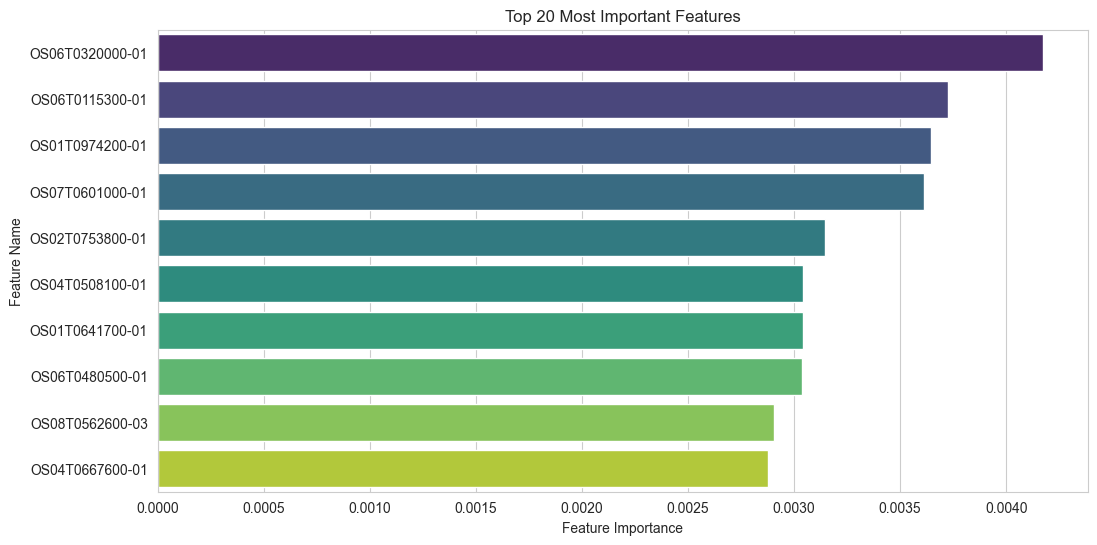

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 获取特征重要性
feature_importances = best_rf_model.feature_importances_
feature_names = X.columns[selector.get_support()]  # 获取被选中的特征名称

# 创建 DataFrame 并按重要性排序
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# 画出特征重要性条形图
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Most Important Features')
plt.show()


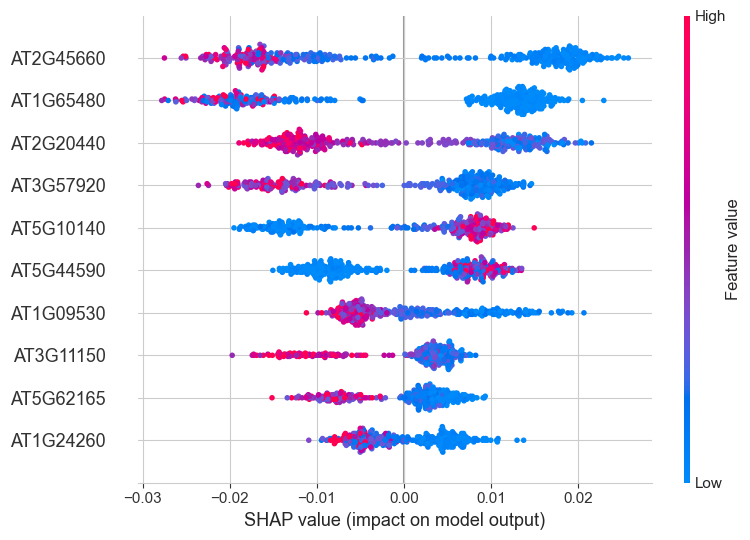

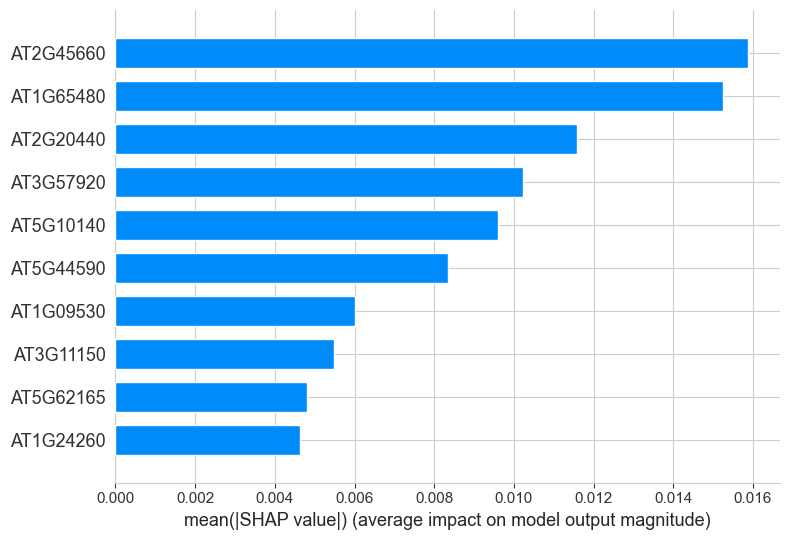

ValueError: Shape of passed values is (1904, 1), indices imply (1904, 1904)

In [37]:
import shap
import matplotlib.pyplot as plt

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 使用训练好的模型来生成SHAP值
explainer = shap.Explainer(best_rf_model)
shap_values = explainer.shap_values(X_selected_df)

# 可视化前10个特征的重要性
shap.summary_plot(shap_values, X_selected_df, max_display=10)

# 如果你想要更清晰的单独显示特征重要性的条形图
shap.summary_plot(shap_values, X_selected_df, plot_type="bar", max_display=10)

# 打印前10个重要特征
shap_values_df = pd.DataFrame(shap_values[0], columns=X_selected_df.columns)
mean_shap_values = shap_values_df.abs().mean().sort_values(ascending=False)
top_10_features = mean_shap_values.head(10)
print("Top 10 Features by SHAP Value Importance:")
print(top_10_features)


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

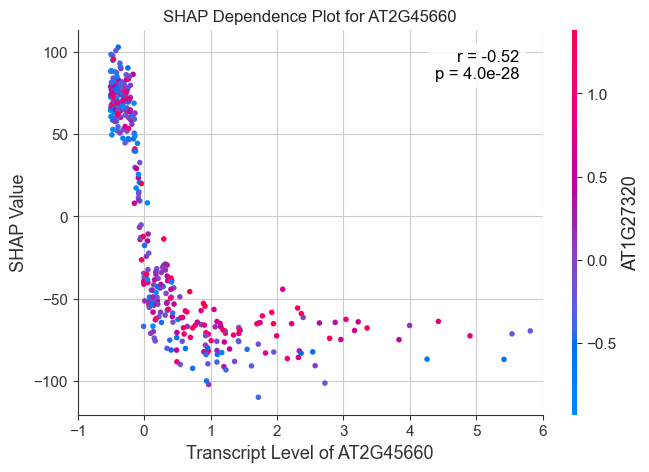

In [28]:
#依赖图
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT2G45660"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_rf_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 1000*4

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 6)

    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

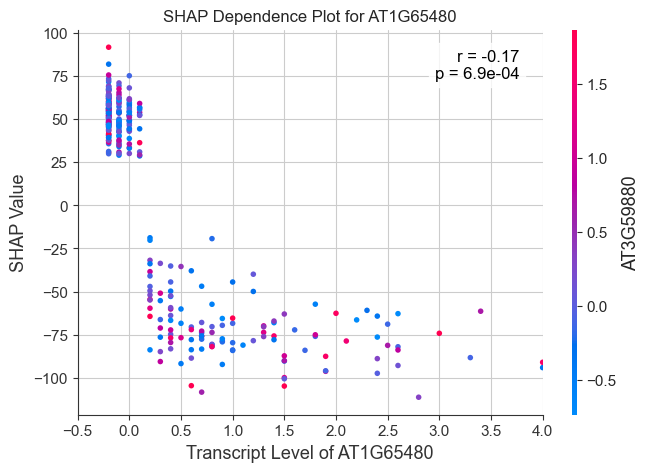

In [31]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT1G65480"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_rf_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 4000

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)
    correlation=    correlation
    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-0.5, 4)

    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

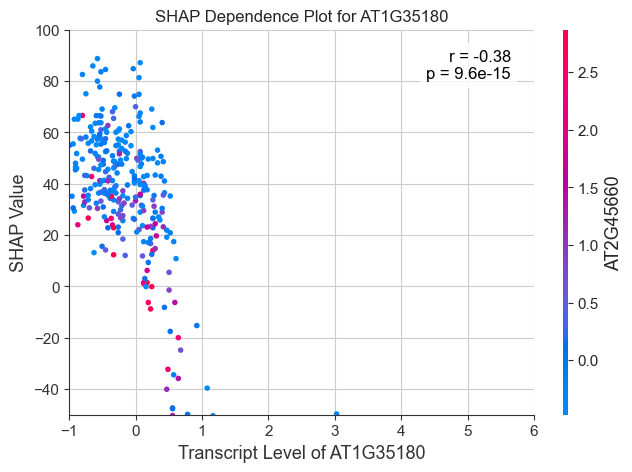

In [33]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT1G35180"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_rf_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 1000*25

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 6)
    plt.ylim(-50, 100)
    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

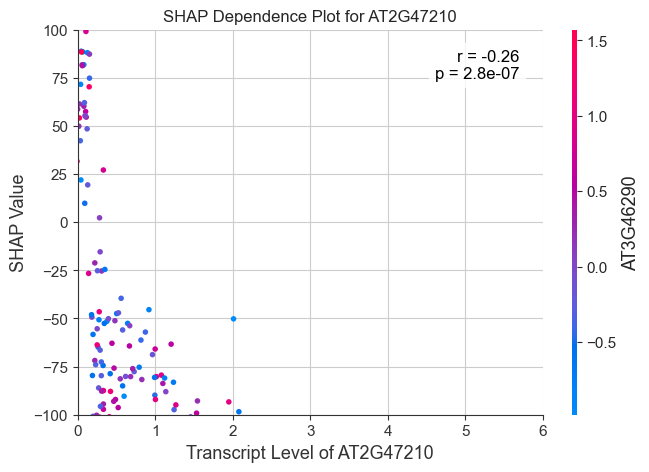

In [14]:
#依赖图
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT2G47210"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_rf_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 1000*20

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(0, 6)
    plt.ylim(-100, 100)
    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

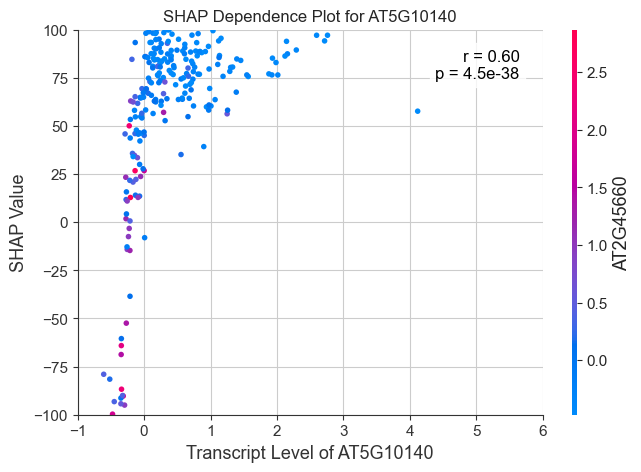

In [26]:
#依赖图
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT5G10140"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_rf_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values *10000

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 6)
    plt.ylim(-100, 100)
    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")
